# KAJMANOSYS
This would be NBA analysis based on kaggle database 2012-2018 box scores.

Prepared by: __Karol Kaufman__  
GitHub: __TurboTiger-DS__  

Quick recap of database:
- Imported from kaggle. 
    - URL: https://www.kaggle.com/pablote/nba-enhanced-stats
    - Author: Paul Rossotti
- The data itself was separated by players. I had stats of each player during each NBA game
- My target was to prepare database to reflect statistic difference of teams and the result of those teams paying against each other. After shaping the database as such, we can try to predict results of future games based on what averages they have before the game.
- After multiple iterations, column renaming and merging of tables, we end up with data just as planned. 
- Data clearing has been performed separately in  _KAJMANOSYS_WORKBOOK.ipynb_

Let's import couple of previously made dataframes to start some exploration.
Python libraries that will also be necessery for exploration - numpy, pandas and matplotlib

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#bs = pd.read_csv('C:\\Users\\Karol\\Desktop\\datareminder\\nba\\kaggle_stats\\2012-18_officialBoxScore.csv')
#pbs = pd.read_csv('.\\kaggle_stats\\2012-18_playerBoxScore.csv')
#additional_tbs = pd.read_csv('C:\\Users\\Karol\\Desktop\\datareminder\\nba\\kaggle_stats\\2012-18_teamBoxScore.csv')
tbsall = pd.read_csv('C:\\Users\\Karol\\Desktop\\datareminder\\nba\\kaggle_stats\\tbsall_4.csv')
#pfrslt = pd.read_csv('C:\\Users\\Karol\\Desktop\\datareminder\\nba\\kaggle_stats\\2012-18_PlayoffRslt.csv', delimiter=';')
tbs  = pd.read_csv('C:\\Users\\Karol\\Desktop\\datareminder\\nba\\kaggle_stats\\tbs_gameNo.csv')

## Data exploration 

 Let's explore some variables.
 I'm gonna define function to draw some plots for all teams, highlighting champions from particular season. 

In [4]:
def nbaplot(stat, year, team=None):
    
    '''Function plotting avg/var stats from tbs table per team. 
    If you are really curious you can specify team= parameter to get pot only for one team'''
        
    if team is None:
        df_to_plot = tbs[np.logical_and(tbs['season'] == year, tbs['teamGameNumber']>5)]
    else:
        df_to_plot = tbs[np.logical_and(tbs['season'] == year, tbs['teamGameNumber']>5)]
        df_to_plot = df_to_plo
        t[df_to_plot.teamAbbr == team]
    team_list = list(dict.fromkeys(list(zip(df_to_plot.teamAbbr, df_to_plot.playoffRslt))))
    fig1 = plt.figure(figsize=(32,20), facecolor='#cccccc')

    for team in team_list:
        marker_type = ''
        mark = ''
        markersize = 0
        opa = 0 
        if team[1] == 5:
            marker_type = '*'
            markersize = 20
            mark = 'Champion'
            opa = 1
        elif team[1] >= 3:
            mark = 'Top4-Team'
            opa = 1
        else:
            mark = 'NoPlayoffTeam'
            opa = 0.2
        x = df_to_plot[df_to_plot.teamAbbr == team[0]]['teamGameNumber']
        y = df_to_plot[df_to_plot.teamAbbr == team[0]][stat]
        plt.plot(x, y, color='Black', alpha=opa, marker=marker_type, MarkerSize=markersize,label=mark, linewidth=2)

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    fonttitle = {'size':40}
    fontaxis = {'size':20}
    plt.legend(by_label.values(), by_label.keys(), prop={'size':30})
    title_text = 'Team ' + stat + '(' + str(year) + ')'
    plt.title(label=title_text, fontdict=fonttitle)
    plt.xlabel('GameNo', fontdict=fontaxis)
    plt.ylabel(stat, fontdict=fontaxis)
    plt.show()

## Assists of 2017 Warriors

   Here are couple of interesting examples. Ever had a feeling that Golden State Warriors dynasty shared the ball like no other? Curry, Durant and whole team (including centers) shared the ball like no other. 
   It's really outstanding in all of their dynasty seasons (2014-2018). I included 2017 season. Just see how it compares to other top4, or all other teams. It's awesome.

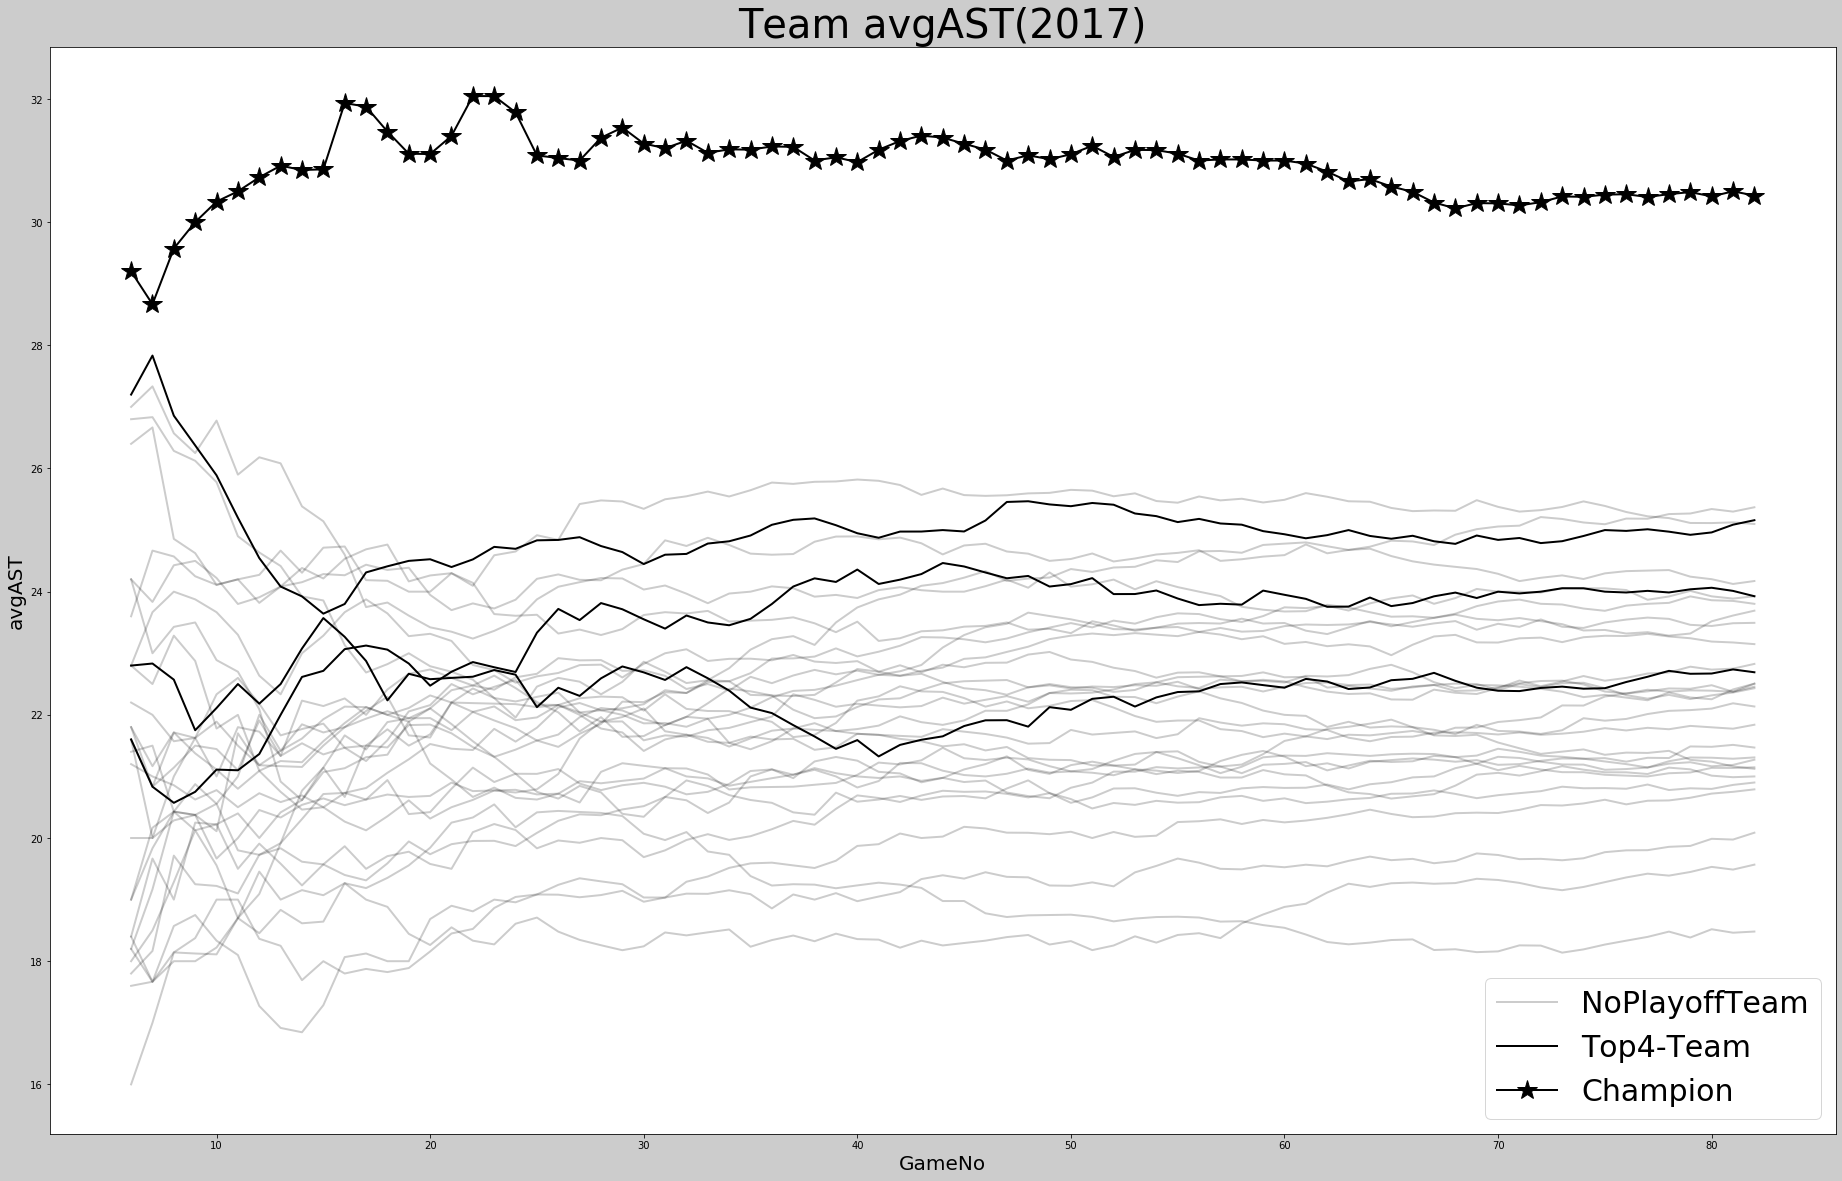

In [5]:
nbaplot('avgAST', 2017)

## 3PM of 2018 Rockets

   Remember who was really close to eliminate great trio of (Curry, Thompson, Durant)?
   It was Houston Rockets due to one reason: huge amount of 3-point shots attempted and made.
   Perhaps it was only way to eliminate GSW from championship contention, the strategy however fell short when Rockets shot abysmal 15.9%(!!!) from 3 in the 7th game of 3-3 Western Conference Finals.

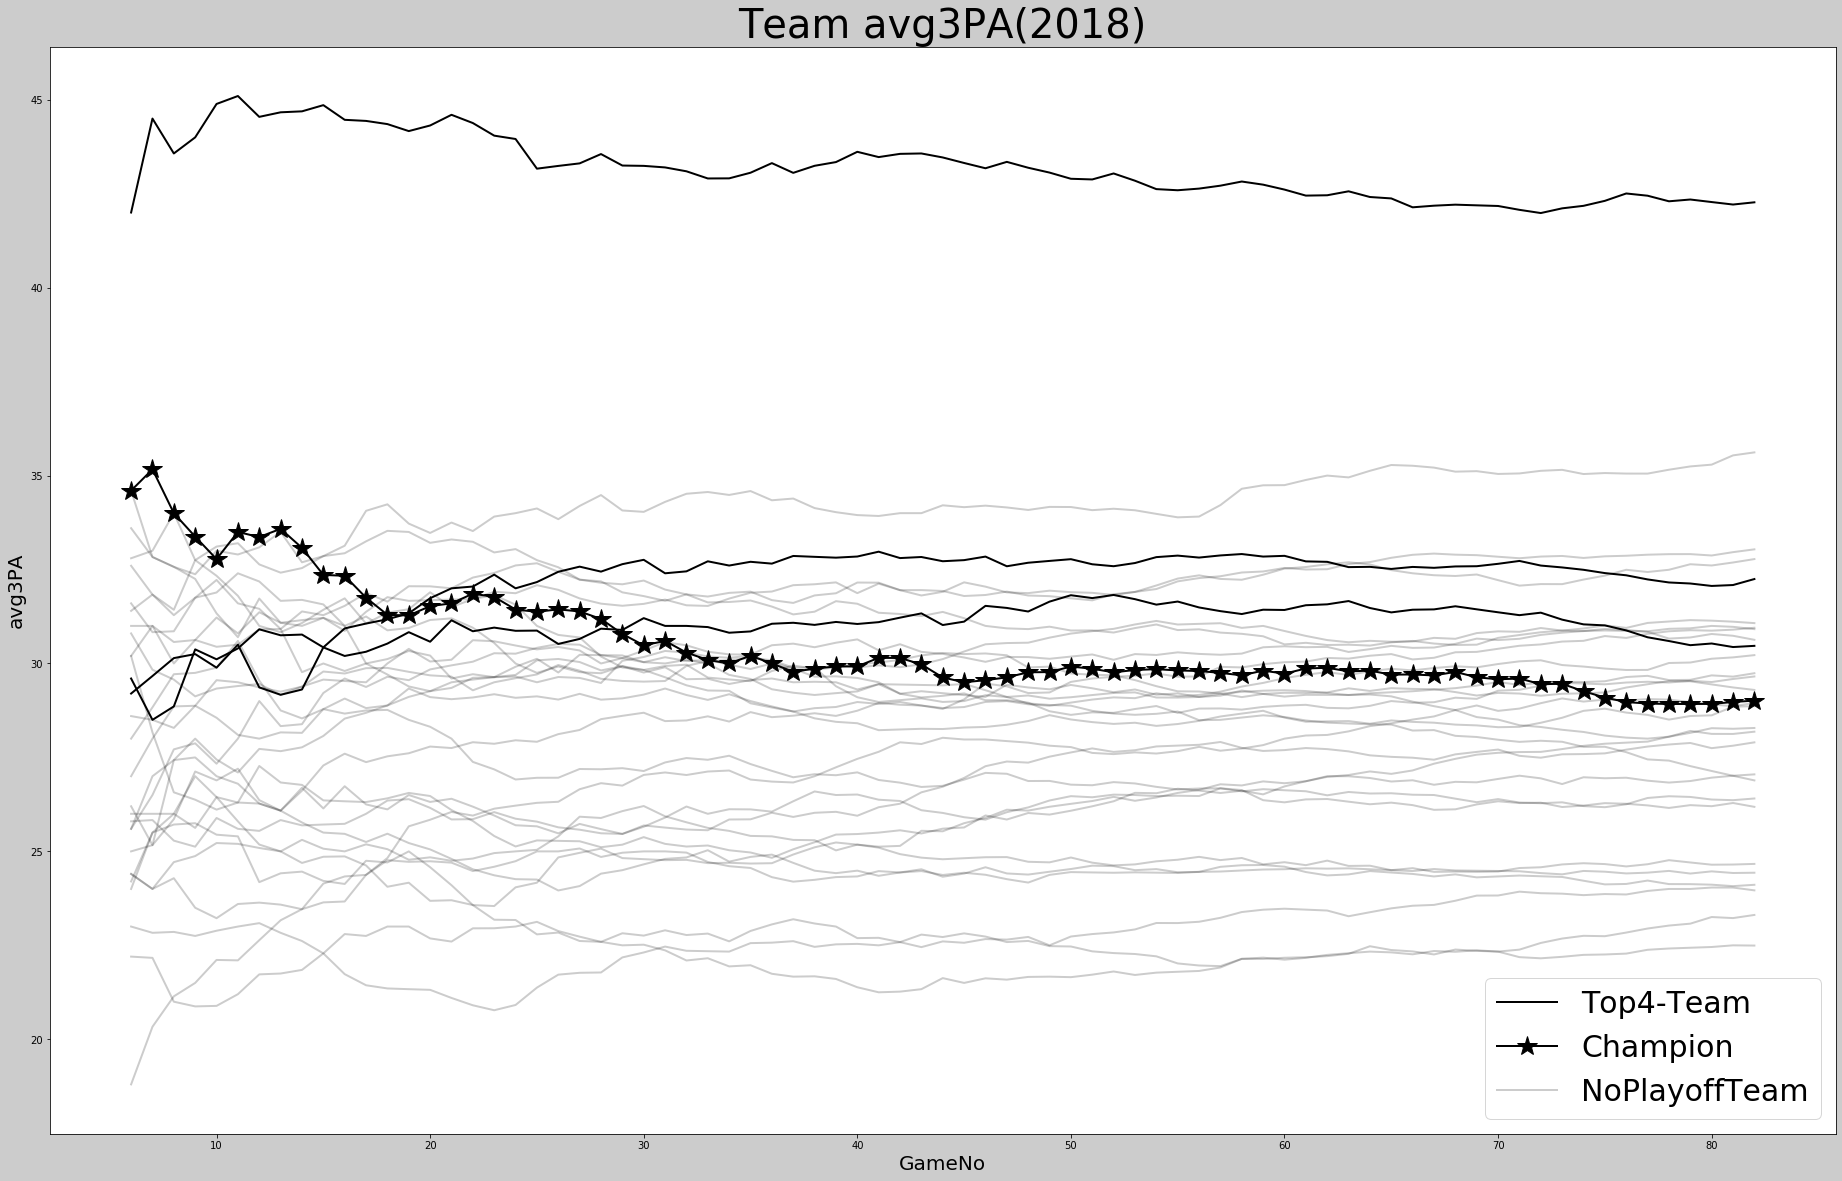

In [6]:
nbaplot('avg3PA', 2018)


# Models

> __"Let's start some machine learning cause i'm bored"__ - _last words before great disaster in 2020_
  
    

For the time being we'll treat all 'avg*' and 'var*' columns as input variables.
The Output of the model should be Win/Loss of the HOME_TEAM.

We'll split the data: Seasons 2013-2017 goes to training subset. - 6080 observations
                      Season 2018 goes to test subset. - 1214 pbservations


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

target  = ['teamRslt']
data_columns = ['avgPTS','avgAST','avgTO','avgSTL','avgBLK','avgPF','avgFGA','avgFGM','avg2PA','avg2PM','avg3PA','avg3PM','avgFTA','avgFTM','avgORB','avgDRB','teamDayOff', 'opptDayOff', 'teamConfInt', 'opptConfInt']
tbsall = tbsall.reset_index(drop=True)

X_train, y_train = tbsall[tbsall['season']<2018][data_columns].values, tbsall[tbsall['season']<2018][target].values
X_test, y_test = tbsall[tbsall['season']==2018][data_columns].values, tbsall[tbsall['season']==2018][target].values



# Standarize the data
scaler = StandardScaler().fit(X_train)
standarized_X = scaler.transform(X_train)
standarized_X_test = scaler.transform(X_test)
X_train = standarized_X
X_test = standarized_X_test


# Entry-level models

We'll create DataFrame modelScores_df to eventually compare models among each other.
Also let's define function to add rows into this dataframe just for fun.

In [8]:
modelScores_df = pd.DataFrame(columns = ['Model','Score'])

def addModelScore(model_name, model_score):
    modelScores_df.loc[len(modelScores_df)+1] = [model_name] + [model_score]

## Logistic Regression 

Let's apply data into simple logistic regression, to figure out what is the score for entry level model. Going forwards we'll try to improve the score as it would be our main validation tool.

In [9]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver='liblinear')
clf.fit(X_train, y_train.ravel())
y_pred = clf.predict(X_test)
logRegScore = clf.score(X_test, y_test)
addModelScore('LogReg', logRegScore)

print('Result of simple logistic regression applied to 2018 test data: ', logRegScore)

Result of simple logistic regression applied to 2018 test data:  0.6463414634146342


## K-Neighbors models

I was sceptical for this model to be effective on the data. But it doesn't hurt to try our chances.

In [10]:
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier()
knn.fit(X_train, y_train.ravel())
y_pred = knn.predict(X_test)
kNeighScore = knn.score(X_test, y_test)

addModelScore('K-Neighbors', kNeighScore)

print('Result of k-neighbors applied to 2018 test data: ' , kNeighScore)

Result of k-neighbors applied to 2018 test data:  0.5642276422764227


# Decision tree classifier
        

In [11]:
from sklearn import tree 
tree_clf = tree.DecisionTreeClassifier()
tree_clf.fit(X_train, y_train.ravel())
y_pred = tree_clf.predict(X_test)
tree_clf_Score = tree_clf.score(X_test, y_test)

addModelScore('Decision Tree', tree_clf_Score)

print('Result of Decision Tree applied to 2018 test data: ' , tree_clf_Score)

Result of Decision Tree applied to 2018 test data:  0.551219512195122


# Hidden layers in our model (2)

In [82]:
from keras.utils import to_categorical 
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.utils import plot_model

y_train[y_train=='Win'] = 1
y_train[y_train=='Loss'] = 0
y_test[y_test=='Win'] = 1
y_test[y_test=='Loss'] = 0

target_train = to_categorical(y_train)
target_test = to_categorical(y_test)
n_variables = X_train.shape[1]

target_test_lateseason = target_test[300:]
X_test_lateseason = X_test[300:]


#Hidden layer structure
model = Sequential()
model.add(Dense(4,activation='relu', input_shape = (n_variables,)))
model.add(Dense(2,activation='relu', input_shape = (2,)))
model.add(Dense(2, activation='sigmoid'))

opt = SGD(lr=0.05, momentum=0.5)
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=30)
    
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy']) 
model.fit(X_train, target_train, validation_data=(X_test_lateseason, target_test_lateseason), epochs=500
          , callbacks=[es]
         )
    



Train on 6149 samples, validate on 930 samples
Epoch 1/500
6149/6149 [==============================] - 1s 94us/step - loss: 0.6846 - accuracy: 0.5765 - val_loss: 0.6792 - val_accuracy: 0.5860
Epoch 2/500
6149/6149 [==============================] - 0s 39us/step - loss: 0.6773 - accuracy: 0.5903 - val_loss: 0.6780 - val_accuracy: 0.5871
Epoch 3/500
6149/6149 [==============================] - 0s 37us/step - loss: 0.6743 - accuracy: 0.5944 - val_loss: 0.6721 - val_accuracy: 0.5919
Epoch 4/500
6149/6149 [==============================] - 0s 36us/step - loss: 0.6647 - accuracy: 0.6091 - val_loss: 0.6547 - val_accuracy: 0.6247
Epoch 5/500
6149/6149 [==============================] - 0s 42us/step - loss: 0.6500 - accuracy: 0.6359 - val_loss: 0.6409 - val_accuracy: 0.6484
Epoch 6/500
6149/6149 [==============================] - 0s 44us/step - loss: 0.6406 - accuracy: 0.6463 - val_loss: 0.6366 - val_accuracy: 0.6532
Epoch 7/500
6149/6149 [==============================] - 0s 37us/step - loss:

plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.show()

plot_model(model, show_shapes=True)



### I noticed that first 1/5 of season is unpredictable. We'll try to train and test data only on games which occurs after 1-2 months into a season

(4949, 20)
(4949, 1)
(990, 20)
(990, 1)
Train on 4949 samples, validate on 990 samples
Epoch 1/500
4949/4949 [==============================] - 0s 95us/step - loss: 0.6842 - accuracy: 0.5720 - val_loss: 0.6753 - val_accuracy: 0.5909
Epoch 2/500
4949/4949 [==============================] - 0s 43us/step - loss: 0.6659 - accuracy: 0.6081 - val_loss: 0.6610 - val_accuracy: 0.6141
Epoch 3/500
4949/4949 [==============================] - 0s 42us/step - loss: 0.6527 - accuracy: 0.6322 - val_loss: 0.6480 - val_accuracy: 0.6333
Epoch 4/500
4949/4949 [==============================] - 0s 41us/step - loss: 0.6436 - accuracy: 0.6499 - val_loss: 0.6414 - val_accuracy: 0.6439
Epoch 5/500
4949/4949 [==============================] - 0s 47us/step - loss: 0.6371 - accuracy: 0.6510 - val_loss: 0.6383 - val_accuracy: 0.6505
Epoch 6/500
4949/4949 [==============================] - 0s 40us/step - loss: 0.6307 - accuracy: 0.6552 - val_loss: 0.6347 - val_accuracy: 0.6601
Epoch 7/500
4949/4949 [==============

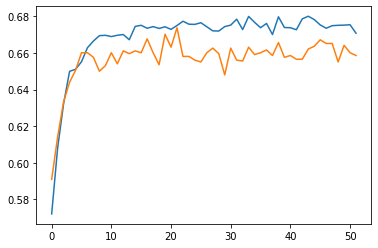

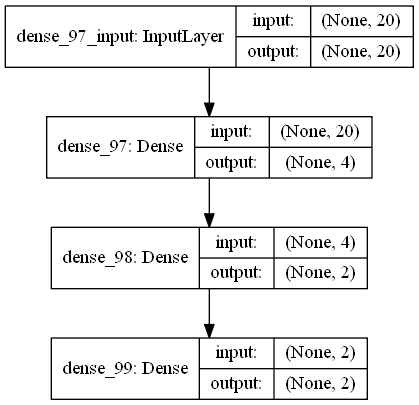

In [98]:
tbsall_game = pd.read_csv('C:\\Users\\Karol\\Desktop\\datareminder\\nba\\kaggle_stats\\tbsall_gameNo.csv')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

target  = ['teamRslt']
data_columns = ['avgPTS','avgAST','avgTO','avgSTL','avgBLK','avgPF','avgFGA','avgFGM','avg2PA','avg2PM','avg3PA','avg3PM','avgFTA','avgFTM','avgORB','avgDRB','teamDayOff', 'opptDayOff', 'teamConfInt', 'opptConfInt']
tbsall = tbsall.reset_index(drop=True)

X_train_n, y_train_n = tbsall_game[np.logical_and(tbsall_game['season']<2018, tbsall_game['teamGameNumber']>8)][data_columns].values, tbsall_game[np.logical_and(tbsall_game['season']<2018, tbsall_game['teamGameNumber']>8)][target].values
X_test_n, y_test_n = tbsall_game[np.logical_and(tbsall_game['season']==2018, tbsall_game['teamGameNumber']>8)][data_columns].values, tbsall_game[np.logical_and(tbsall_game['season']==2018, tbsall_game['teamGameNumber']>8)][target].values



# Standarize the data
scaler = StandardScaler().fit(X_train_n)
standarized_X_n = scaler.transform(X_train_n)
standarized_X_test_n = scaler.transform(X_test_n)
X_train_n = standarized_X_n
X_test_n = standarized_X_test_n

print(X_train_n.shape)
print(y_train_n.shape)
print(X_test_n.shape)
print(y_test_n.shape)


y_train_n[y_train_n=='Win'] = 1
y_train_n[y_train_n=='Loss'] = 0
y_test_n[y_test_n=='Win'] = 1
y_test_n[y_test_n=='Loss'] = 0

target_train_n = to_categorical(y_train_n)
target_test_n = to_categorical(y_test_n)
n_variables_n = X_train_n.shape[1]








model_n = Sequential()
model_n.add(Dense(4,activation='relu', input_shape = (n_variables_n,)))
model_n.add(Dense(2,activation='relu', input_shape = (2,)))
model_n.add(Dense(2, activation='sigmoid'))

opt = SGD(lr=0.05, momentum=0.5)
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=30)
    
model_n.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy']) 
model_n.fit(X_train_n, target_train_n, validation_data=(X_test_n, target_test_n), epochs=500
          , callbacks=[es]
         )


plt.plot(model_n.history.history['accuracy'])
plt.plot(model_n.history.history['val_accuracy'])
plt.show()

plot_model(model_n, show_shapes=True)



# Model accuracy summarized

As for now pretty understandable. Combining all accuracies to have simple overview on the barplot.

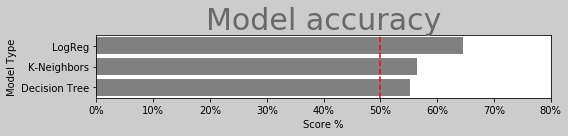

In [36]:
import matplotlib.ticker as mticks


ax = plt.subplots(figsize=(8,2), facecolor='#cccccc')
plt.rcParams.update({'figure.autolayout': True})
ax = sns.barplot(x='Score', y='Model', data=modelScores_df,  color='gray')
#axes, labels and so on.
ax.set(xlim=[0.0, 0.8], xlabel='Score %', ylabel='Model Type')
ax.set_title('Model accuracy', fontsize=30, color='dimgray')
#% xAxis
ax.xaxis.set_major_formatter(mticks.PercentFormatter(1.0))
#adding vertical line indicating coin-toss probability
ax.axvline(0.5, ls='--', color='r')

plt.show()